Learning outcome:
* Explain the structure of Shor's 9-qubit code from the perspective of combining the three-qubit phase- and bit-flip codes
* See how Shor's code can correct more than just single-qubit errors

In [1]:
import numpy as np
import pennylane as qml

![Shor's code is based on the three-qubit bit-flip and phase-flip codes:](./images/E.2.1.png)
Given that Shor's code is a mashup of the bit-flip and phase-flip codes, it isn't surprising to hear that it can decode any error of the form:
$$ E = \left( \bigotimes_{i=0}^{j-1} I_i \right) \otimes P_j \otimes \left( \bigotimes_{i=j+1}^{8} I_i \right),
$$
where $P_j \in \{I, X_j, Y_j, Z_j\}$ is a Pauli error on qubit $j \in \{0,1,2,...,8\}$.

**Codercise E.3.1**
It turns out that Shor's code can even decode multi-qubit Pauli errors. So let's create a function that can generate any error we please. We'll use this extensively going forward.
The function that is available to you is called `error`. It takes two jeyword arguments:
1. `error-type`: a string associated with the error you'd like to create and
2. `wires`: a `list` of wires that the error acts on.

For example, if you want to create a $Y$ error on qubit 7, you would do `error(error_type = "Y", wires = [7])`. If you want to create an $XYZ$ error - a three-qubit error - where qubit 4,5 and 1 get the $X$,$Y$,$Z$ error, respectively, you would do `error(errpr_type= "XYZ", wires = [4,5,1])`.
The `error` function will return a list of Pennylane operators associated to each error. For example, for the `XYZ` on qubit 4,5, and `error` would return `[qml.PauliX(4), qml.PauliY(5), qml.PauliZ(1)]`.

In [6]:
from typing import List


def error(error_type: str, wires: List[int]):
    """
    Creates a list of quantum gates based on the error type and wires provided.

    Parameters:
    error_type (str): The type of error, which determines the gate to be applied.
    wires (List[int]): The list of wires that the error acts on.

    Returns:
    List: A list of quantum gates corresponding to the error type applied to the given wires.
    """
    gate_map = {
        'X': qml.PauliX,
        'Y': qml.PauliY,
        'Z': qml.PauliZ
    }

    return  [gate_map[et](wire) for et, wire in zip(error_type, wires)]

# Now let's call the error function with the specified parameters.
error_gates = error('YYZ', [4, 5, 1])
error_gates


[PauliY(wires=[4]), PauliY(wires=[5]), PauliZ(wires=[1])]

In [7]:
# Create a Z error on qubit 4
z_error_4 = error(error_type = "Z", wires = [4])

# Create a YX error on qubits 8 and 0
yx_error_80 = error(error_type = "YX", wires = [8,0])

# Create a XXZZYY error on qubits 1, 2, 3, 4, 5, and 0.
xxzzyy_error_123450 = error(error_type = "XXZZYY", wires = [1,2,3,4,5,0])

**Codercise E.3.2.**
Complete the `shor` QNode below such that it performs exactly what the diagram above shows. The sate $\Ket{\psi}$ that gets encoded is an arbitrary quantum state; it doesn't matter what it is. We''ve left it as an argument -`state`- to the `shor` function, where you can initialize $\Ket{\psi}$ to be `state` by using `qml.QubitStateVector`.
You'll also notice that the error is applied for you already in the middle of the `shor` function.Because `error` returns a list of PennyLane operators, we can iterate through its elements and apply each error very easily.

In [37]:
dev = qml.device("default.qubit", wires=9)

@qml.qnode(dev)
def shor(state, error_type, wires):
    """A quantum circuit that implements Shor's 9-qubit code

    Args:
        state (tensor): a numpy array representing a 1-qubit state: alpha |0> + beta |1>
                        This is used to initialize the 0th wire with qml.QubitStateVector
        error_type (str): for example, XX, YY, XZ, YZ.
        wires (list(int)): the wires the error acts on.

    Returns:
        (tuple(tensor, tensor)): the separate probability distributions over the 0th wire (|psi>)
        and all 8 ancillary qubits in that order.
    """
    qml.QubitStateVector(state,wires=0)

    qml.CNOT(wires=[0,3])
    qml.CNOT(wires=[0,6])

    qml.broadcast(qml.Hadamard, wires=[0,3,6], pattern='single')
    qml.broadcast(qml.CNOT,wires=[0,1,3,4,6,7], pattern='double')
    qml.broadcast(qml.CNOT,wires=[0,2,3,5,6,8], pattern='double')

    # apply the error
    for err in error(error_type=error_type, wires=wires):
        err

    qml.broadcast(qml.CNOT,wires=[0,1,3,4,6,7], pattern='double')
    qml.broadcast(qml.CNOT,wires=[0,2,3,5,6,8], pattern='double')

    qml.Toffoli(wires=[2,1,0])
    qml.Toffoli(wires=[5,4,3])
    qml.Toffoli(wires=[8,7,6])

    qml.broadcast(qml.Hadamard, wires=[0,3,6], pattern='single')
    qml.CNOT(wires=[0,3])
    qml.CNOT(wires=[0,6])
    qml.Toffoli(wires=[6,3,0])

    return qml.probs(wires=0), qml.probs(wires=range(1, 9))

(<Figure size 1224x720 with 1 Axes>, <Axes:>)


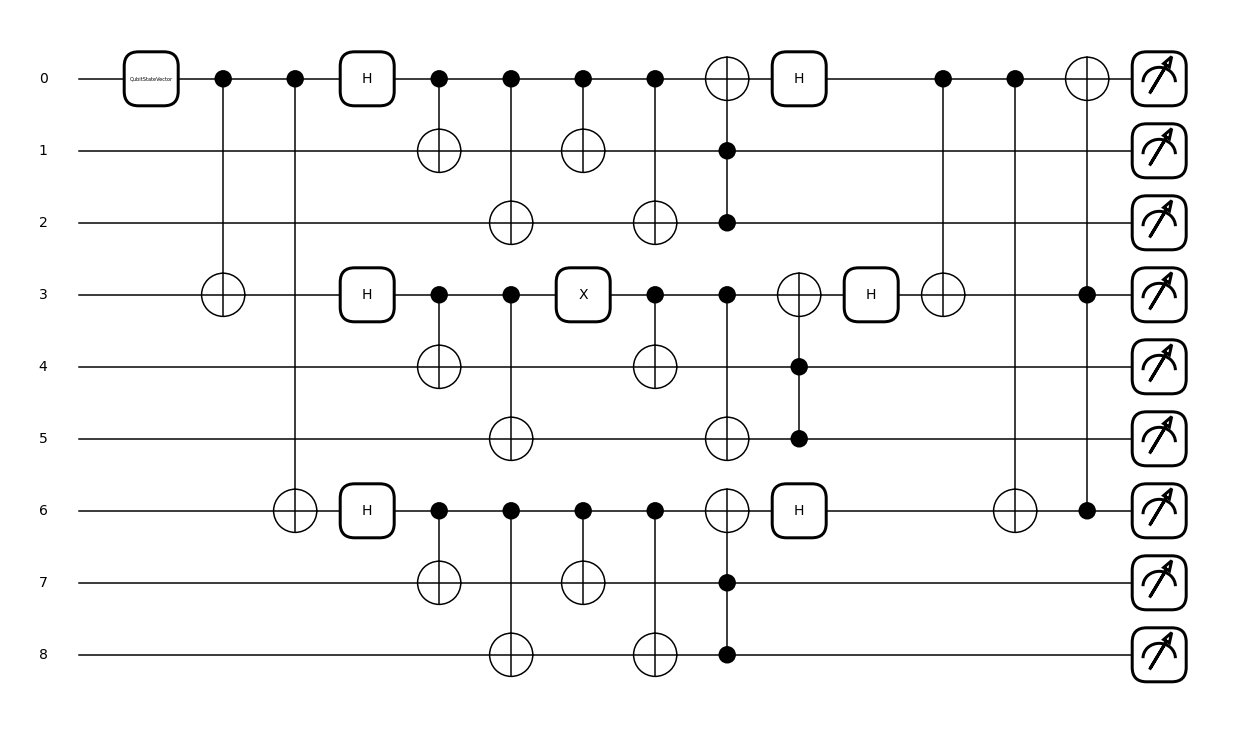

In [15]:
print(qml.draw_mpl(shor)(np.array([1,0]), 'X',wires=[3]))

In [38]:
prob0= shor(np.array([1,0]), 'X',wires=[3])
prob0

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

The `shor` function returns a tuple of two probability distributions:$\left( \left| \langle 0 | \psi \rangle \right|^2, \left| \langle 1 | \psi \rangle \right|^2 \right)$ - `qml.probs(wires = 0)` - and $|\langle \sigma_8 | s_e \rangle |^2$ (`qml.probs(wires=range(1,9))`) for $\sigma_8 \in \{0,1\}^8 $.Since probability distributions lack relative phase information, for simplicity we'll only feed into the `shor` function those states that have positive and real coefficients. We can verify that Shor's code decodes our input state $\Ket{\psi}$ by checking if the output of `shor(state, error_type, wires)[0]` is the probability distribution defined by $\Ket{\psi}$


**Codercise E.3.3.**
Complete the `decoded` function below that will check to see  if, given an error, Shor's code can correctly decode the input `state`. You have access to the `shor` function from before, as well as a function called `ranndom_state` that can be used to creare a random 1-qubit state (we will use it to initialize $\Ket{\psi}$) with positive and real coefficients.
This code will print out a list of `True`/`False` for each possible single-qubit Pauli error that can occur (see `single_qubit_errors`).

Hint:
Remember - `shor` outputs two probability distributions, one for the register belongings to $\Ket{\psi}$ and the other for the error syndrome. If Shor's code successfully de codes the input state, then that means $\Ket{\psi}$, and its probability distribution, is the same as when it entered the circuit.
To take a quantim staet and turn it  into a probability distribution, you need to do an element-wise multiplication with its conjugate. The function `np.conj(state)` you will get the conjugated form of `state`. Compare that result to what `shor` gives.

In [39]:
def decoded(state, error_type, wires):
    """Tells us whether the state was decoded by Shor's code

    Args:
        state (tensor): a numpy array representing a 1-qubit state: alpha |0> + beta |1>
        error_type (str): for example, XX, YY, XZ, YZ.
        wires (list(int)): the wires the error acts on.

    Returns:
        (bool): True if state is decoded successfully, False if not.
    """
    prob0 = shor(state,error_type, wires)[0]
    expected_prob0 = np.abs(state)**2

    # Compare the two probability distributions
    # Here we use np.allclose to check if the two arrays are element-wise equal within a tolerance
    return np.allclose(prob0, expected_prob0)

state = np.array([1,0])

single_qubit_errors = [["X", [i]] for i in range(9)]
single_qubit_errors += [["Y", [i]] for i in range(9)]
single_qubit_errors += [["Z", [i]] for i in range(9)]

decoded_list = []

for err in single_qubit_errors:
    decoded_list.append(decoded(state, *err))

print(decoded_list)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


**Codercise E.3.4.a.**
 Complete the `find_the_one` function such that it outputs the index $i \in [0,255]$ corresponding to where the error syndrome is equal to 1.

Hint
Using np.nonzero might be useful.

Also, remember that the second element of the output of the shor function gives the error syndrome.

In [40]:
def find_the_one(syndrome):
    """Finds the entry in the error syndrome that is equal to 1.

    Args:
        syndrome (tensor): The second output of the shor function — qml.probs(wires=range(1, 9))

    Returns:
        (int): the index of the syndrome vector that is equal to 1. For example,
        if syndrome = [0, 0, 1, 0], then this function would return 2.
    """
    non_zero_indexes = np.nonzero(syndrome)[0]

    # If there is no non-zero index, return None or raise an error as appropriate for the context
    if len(non_zero_indexes) == 0:
        return None

    return non_zero_indexes[0]


**Codercise E.3.4.b.**
 Now that we can analyze the error syndrome from Shor's code, let's look for unique error syndromes. In doing this, not only are the errors decodable, but for some we might be even able to tell what the error was.

Running the code below will print out a dictionary of errors that yield the same error syndrome. For example, each entry in the dictionary will look like this:

In [ ]:
single_qubit_errors = [["X", [i]] for i in range(9)]
single_qubit_errors += [["Y", [i]] for i in range(9)]
single_qubit_errors += [["Z", [i]] for i in range(9)]

all_syndromes = []
unique_syndromes = []
degenerate_syndromes = {}

state = random_state()

for err in single_qubit_errors:
    ind = find_the_one(shor(state, *err)[1])

    if ind in unique_syndromes:
        # find other error that gave the same syndrome
        other_ind = np.where(np.array(all_syndromes) == ind)[0].item()
        unique_syndromes.remove(ind) # remove it from the unique syndromes
        degenerate_syndromes[ind] = [single_qubit_errors[other_ind], err]

    elif ind in degenerate_syndromes.keys():
        degenerate_syndromes[ind].append(err)

    else:
        unique_syndromes.append(ind)

    all_syndromes.append(ind)

################
# PRESS SUBMIT #
################

print(degenerate_syndromes)
